In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import models
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, ConvLSTM2D, MultiHeadAttention, Flatten, MaxPooling3D, BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DIR = "drive/MyDrive/dataset3"

In [ ]:
# cek
os.listdir(DIR)

['train', 'val']

In [ ]:
print("file train/fight: ",len(os.listdir(DIR+"/train/Fight")))
print("file train/nonfight:", len(os.listdir(DIR+"/train/NonFight")))
print("file val/fight: ", len(os.listdir(DIR+"/val/Fight")))
print("file val/nonfight: ", len(os.listdir(DIR+"/val/NonFight")))

file train/fight:  800
file train/nonfight: 800
file val/fight:  200
file val/nonfight:  200


In [ ]:
class FrameGenerator:
    def __init__(self, path, training=False):
        """ Returns a set of frames with their associated label.
          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path

        self.training = training
        self.class_names = ['NonFight', 'Fight']
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        if self.training:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        else:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        classes = [p.parent.name for p in video_paths]

        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames, flow = self.read_npy_file(path)
            label = self.class_ids_for_name[name]
            label = tf.keras.utils.to_categorical(label, num_classes=len(self.class_names))
            yield video_frames, label


    def read_npy_file(self, path):
        data = np.load(path)
        data = np.float32(data)
        data = data/255.0

        frame = data[:, :, :, :3]
        flow = data[:, :, :, 3:]

        return frame, flow

In [ ]:
train_file = Path(DIR).joinpath("train").with_suffix('')
test_file = Path(DIR).joinpath("val").with_suffix('')
train_file

PosixPath('drive/MyDrive/dataset3/train')

In [ ]:
fg = FrameGenerator(train_file, training=True)

# test
frames, label = next(fg())
print(fg)
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (20, 224, 224, 3)
Label: [1. 0.]


In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=3)
  return embed.embed_file('./animation.gif')


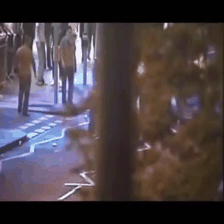

In [ ]:
to_gif(frames)

In [ ]:
# buat tf.data.Dataset
batch_size = 8

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(2,), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_file, training=True),
                                          output_signature=output_signature)


test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_file),
                                          output_signature=output_signature)


In [ ]:
train_ds = train_ds.shuffle(buffer_size=1000)
test_ds = test_ds.shuffle(buffer_size=1000)

In [ ]:
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# test data
for frames, labels in train_ds.take(5):
    print(labels)

print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

tf.Tensor(
[[0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]], shape=(8, 2), dtype=int16)
tf.Tensor(
[[0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]], shape=(8, 2), dtype=int16)
Shape: (8, 20, 224, 224, 3)
Label: (8, 2)


In [ ]:
def plot_history2(history):
    # Define the metrics you want to plot
    metrics = list(history.keys())[:3]

    # Determine the number of plots needed
    num_plots = len(metrics)

    # Adjust the figsize to accommodate more plots
    plt.figure(figsize=(7 * num_plots, 5))

    for i, metric in enumerate(metrics):
        # Plot training & validation metric values
        plt.subplot(1, num_plots, i + 1)
        plt.plot(history[metric])
        plt.plot(history[f'val_{metric}'])
        plt.title(f'Model {metric.capitalize()}')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


# **Pretrained ResNet**

In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg',
                                                  weights='imagenet')

In [ ]:
# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (20, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 20, 7, 7, 2048)       2358771   ['input_4[0][0]']             
 stributed)                                               2                                       
                                                                                                  
 conv_lstm2d_2 (ConvLSTM2D)  (None, 20, 7, 7, 256)        2123468   ['time_distributed_1[0][0]']  
                                                          8                                       
                                                                                            

In [ ]:
epochs = 20
lr = 1e-6

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy', AUC(multi_label=False)])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/20
200/200 [==============================] - 309s 1s/step - loss: 0.6925 - accuracy: 0.5550 - auc: 0.5706 - val_loss: 0.6928 - val_accuracy: 0.5000 - val_auc: 0.5134
Epoch 2/20
200/200 [==============================] - 99s 495ms/step - loss: 0.6892 - accuracy: 0.6381 - auc: 0.6830 - val_loss: 0.6871 - val_accuracy: 0.5575 - val_auc: 0.6435
Epoch 3/20
200/200 [==============================] - 99s 494ms/step - loss: 0.6766 - accuracy: 0.6706 - auc: 0.7355 - val_loss: 0.6591 - val_accuracy: 0.6850 - val_auc: 0.7624
Epoch 4/20
200/200 [==============================] - 99s 495ms/step - loss: 0.6348 - accuracy: 0.7119 - auc: 0.7754 - val_loss: 0.5975 - val_accuracy: 0.6925 - val_auc: 0.7937
Epoch 5/20
200/200 [==============================] - 100s 499ms/step - loss: 0.5586 - accuracy: 0.7544 - auc: 0.8215 - val_loss: 0.5335 - val_accuracy: 0.7350 - val_auc: 0.8200
Epoch 6/20
200/200 [==============================] - 99s 495ms/step - loss: 0.4788 - accuracy: 0.7887 - auc: 0.8636

In [ ]:
result_metric = model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 7s 147ms/step - loss: 0.5100 - accuracy: 0.7425 - auc: 0.8275


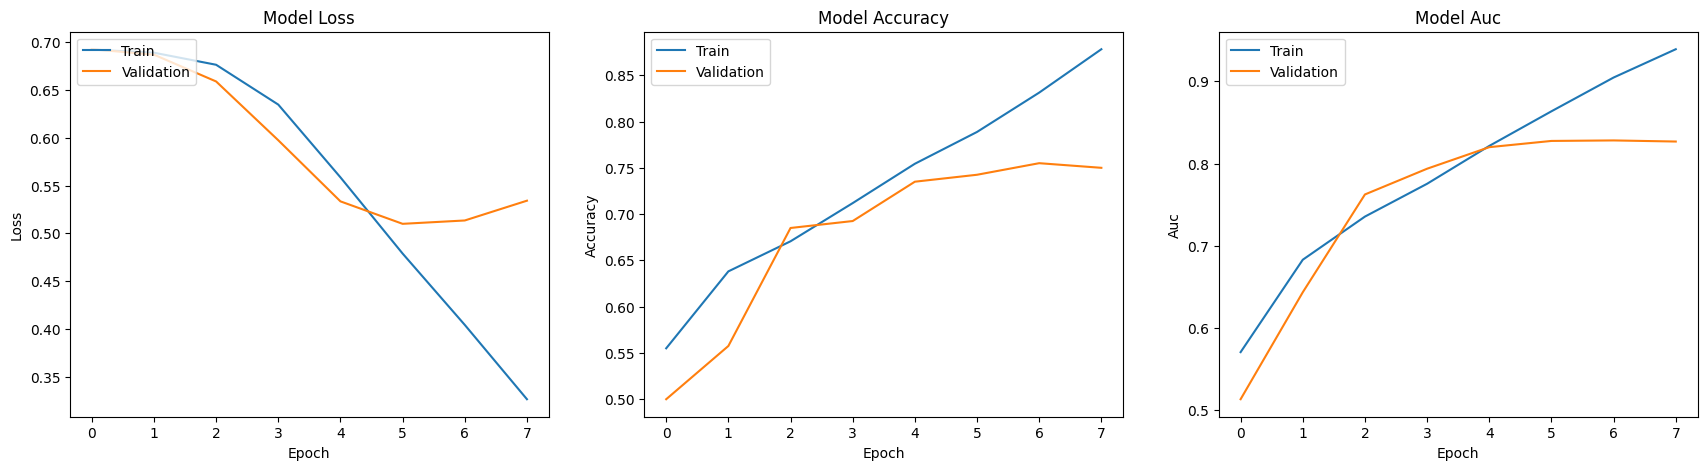

In [ ]:
plot_history2(results.history)

In [ ]:
result_metric

{'loss': 0.509965181350708,
 'accuracy': 0.7425000071525574,
 'auc': 0.827528178691864}

In [ ]:
results.history

{'loss': [0.6924836039543152,
  0.6891995072364807,
  0.67655348777771,
  0.6348379254341125,
  0.5586410760879517,
  0.47883209586143494,
  0.4041110873222351,
  0.32626086473464966],
 'accuracy': [0.5550000071525574,
  0.6381250023841858,
  0.6706249713897705,
  0.7118750214576721,
  0.7543749809265137,
  0.7887499928474426,
  0.831250011920929,
  0.878125011920929],
 'auc': [0.5706218481063843,
  0.6830269694328308,
  0.7355084419250488,
  0.7754294872283936,
  0.8214583992958069,
  0.863579511642456,
  0.904659628868103,
  0.9390810132026672],
 'val_loss': [0.6928373575210571,
  0.687126636505127,
  0.6590756177902222,
  0.5974720120429993,
  0.5334861874580383,
  0.509965181350708,
  0.513475239276886,
  0.5342028737068176],
 'val_accuracy': [0.5,
  0.5575000047683716,
  0.6850000023841858,
  0.6924999952316284,
  0.7350000143051147,
  0.7425000071525574,
  0.7549999952316284,
  0.75],
 'val_auc': [0.5133625268936157,
  0.6434718370437622,
  0.7624281644821167,
  0.793740689754486

In [ ]:
res_metric_ord = result_metric
res_history = results.history

# **Tidak pakai pretrained**

In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg')

# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (20, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model_no_pretrain = tf.keras.Model(inputs=video_input, outputs=dense_4)

model_no_pretrain.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_3 (TimeDi  (None, 20, 7, 7, 2048)       2358771   ['input_9[0][0]']             
 stributed)                                               2                                       
                                                                                                  
 conv_lstm2d_6 (ConvLSTM2D)  (None, 20, 7, 7, 256)        2123468   ['time_distributed_3[0][0]']  
                                                          8                                       
                                                                                            

In [ ]:
epochs = 20
lr = 1e-6

In [ ]:
model_no_pretrain.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy', AUC(multi_label=False)])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
results_no_pt = model_no_pretrain.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/20
200/200 [==============================] - 127s 508ms/step - loss: 0.6890 - accuracy: 0.6031 - auc_1: 0.6392 - val_loss: 0.6927 - val_accuracy: 0.5050 - val_auc_1: 0.5291
Epoch 2/20
200/200 [==============================] - 99s 493ms/step - loss: 0.6678 - accuracy: 0.6725 - auc_1: 0.7230 - val_loss: 0.6498 - val_accuracy: 0.7175 - val_auc_1: 0.7559
Epoch 3/20
200/200 [==============================] - 99s 494ms/step - loss: 0.6103 - accuracy: 0.7181 - auc_1: 0.7820 - val_loss: 0.5548 - val_accuracy: 0.7800 - val_auc_1: 0.8304
Epoch 4/20
200/200 [==============================] - 99s 494ms/step - loss: 0.5289 - accuracy: 0.7569 - auc_1: 0.8350 - val_loss: 0.5003 - val_accuracy: 0.7850 - val_auc_1: 0.8444
Epoch 5/20
200/200 [==============================] - 100s 499ms/step - loss: 0.4488 - accuracy: 0.8031 - auc_1: 0.8818 - val_loss: 0.4789 - val_accuracy: 0.7875 - val_auc_1: 0.8531
Epoch 6/20
200/200 [==============================] - 99s 494ms/step - loss: 0.3641 - accurac

In [ ]:
result_metric_no_pt = model_no_pretrain.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 7s 147ms/step - loss: 0.4738 - accuracy: 0.7875 - auc_1: 0.8595


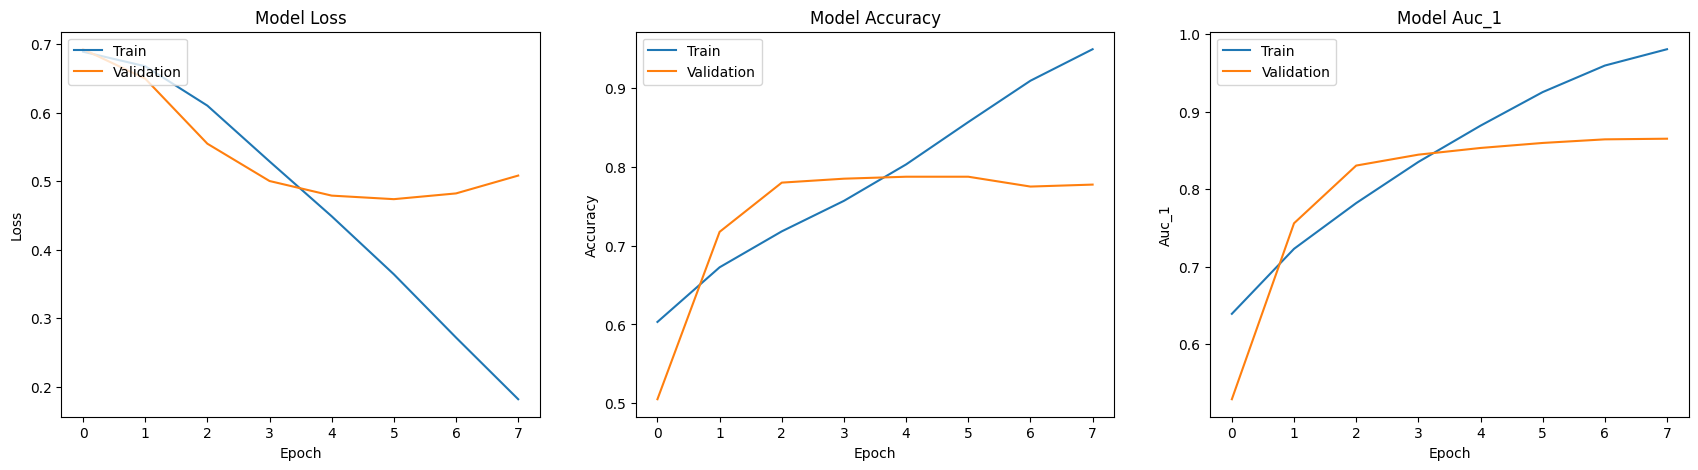

In [ ]:
plot_history2(results_no_pt.history)

# **Freeze resnet pretrained**

In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg', weights='imagenet')
pretrained_model.trainable = False

# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (20, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model_freeze = tf.keras.Model(inputs=video_input, outputs=dense_4)

model_freeze.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_4 (TimeDi  (None, 20, 7, 7, 2048)       2358771   ['input_11[0][0]']            
 stributed)                                               2                                       
                                                                                                  
 conv_lstm2d_8 (ConvLSTM2D)  (None, 20, 7, 7, 256)        2123468   ['time_distributed_4[0][0]']  
                                                          8                                       
                                                                                           

In [ ]:
epochs = 20
lr = 1e-6

In [ ]:
model_freeze.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy', AUC(multi_label=False)])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
results_freeze = model_freeze.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/20
200/200 [==============================] - 63s 266ms/step - loss: 0.6933 - accuracy: 0.4994 - auc_2: 0.4993 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_auc_2: 0.5000
Epoch 2/20
200/200 [==============================] - 51s 253ms/step - loss: 0.6930 - accuracy: 0.5006 - auc_2: 0.5105 - val_loss: 0.6927 - val_accuracy: 0.5000 - val_auc_2: 0.6306
Epoch 3/20
200/200 [==============================] - 51s 253ms/step - loss: 0.6926 - accuracy: 0.5213 - auc_2: 0.5220 - val_loss: 0.6923 - val_accuracy: 0.5000 - val_auc_2: 0.5100
Epoch 4/20
200/200 [==============================] - 50s 253ms/step - loss: 0.6924 - accuracy: 0.5238 - auc_2: 0.5249 - val_loss: 0.6919 - val_accuracy: 0.5100 - val_auc_2: 0.5429
Epoch 5/20
200/200 [==============================] - 51s 258ms/step - loss: 0.6919 - accuracy: 0.5331 - auc_2: 0.5325 - val_loss: 0.6910 - val_accuracy: 0.5175 - val_auc_2: 0.5845
Epoch 6/20
200/200 [==============================] - 50s 252ms/step - loss: 0.6910 - accuracy:

In [ ]:
result_metric_freeze = model_freeze.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 7s 147ms/step - loss: 0.5937 - accuracy: 0.6800 - auc_2: 0.7258


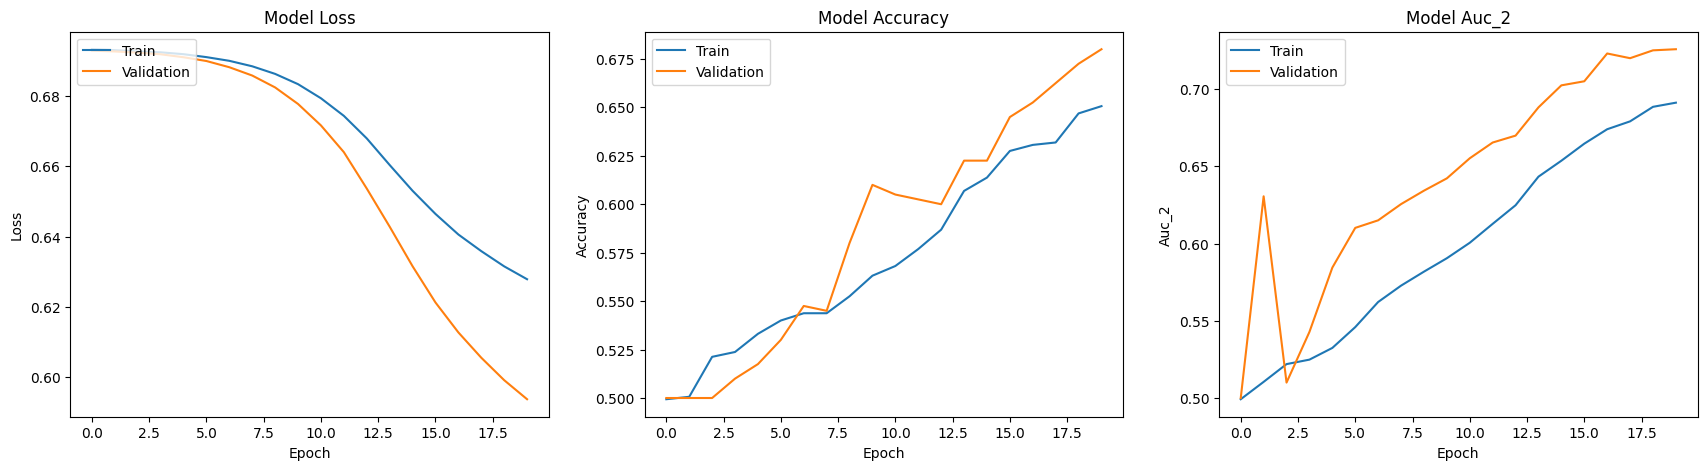

In [ ]:
plot_history2(results_freeze.history)

In [ ]:
result_metric_freeze

{'loss': 0.5937341451644897,
 'accuracy': 0.6800000071525574,
 'auc_2': 0.7257686853408813}

In [ ]:
result_metric

{'loss': 0.509965181350708,
 'accuracy': 0.7425000071525574,
 'auc': 0.827528178691864}

In [ ]:
result_metric_no_pt

{'loss': 0.47377872467041016,
 'accuracy': 0.7875000238418579,
 'auc_1': 0.8595219254493713}

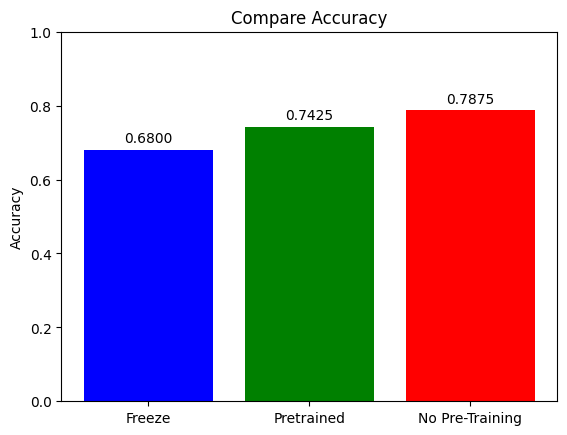

In [ ]:
labels = ['Freeze', 'Pretrained', 'No Pre-Training']
accuracies = [result_metric_freeze['accuracy'], result_metric['accuracy'], result_metric_no_pt['accuracy']]
# Plotting
fig, ax = plt.subplots()
bars = ax.bar(labels, accuracies, color=['blue', 'green', 'red'])

ax.set_ylabel('Accuracy')
ax.set_title('Compare Accuracy')
ax.set_ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show plot
plt.show()

# **tidak pakai attention**

In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg', weights='imagenet')

# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (20, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

# mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# # attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

# conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model_no_att = tf.keras.Model(inputs=video_input, outputs=dense_4)

model_no_att.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 20, 224, 224, 3   0         
                             )]                                  
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 7, 7, 2048)    23587712  
 stributed)                                                      
                                                                 
 conv_lstm2d_10 (ConvLSTM2D  (None, 20, 7, 7, 256)     21234688  
 )                                                               
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 20, 3, 3, 256)     0         
 g3D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 46080)             0  

In [ ]:
epochs = 20
lr = 1e-6

In [ ]:
model_no_att.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy', AUC(multi_label=False)])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
results_no_att = model_no_att.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/20
200/200 [==============================] - 110s 439ms/step - loss: 0.6709 - accuracy: 0.5906 - auc_3: 0.6244 - val_loss: 0.7173 - val_accuracy: 0.4700 - val_auc_3: 0.4711
Epoch 2/20
200/200 [==============================] - 85s 426ms/step - loss: 0.4793 - accuracy: 0.8313 - auc_3: 0.9155 - val_loss: 0.6384 - val_accuracy: 0.6550 - val_auc_3: 0.6868
Epoch 3/20
200/200 [==============================] - 85s 426ms/step - loss: 0.3094 - accuracy: 0.9469 - auc_3: 0.9856 - val_loss: 0.5453 - val_accuracy: 0.7350 - val_auc_3: 0.8013
Epoch 4/20
200/200 [==============================] - 85s 426ms/step - loss: 0.1787 - accuracy: 0.9850 - auc_3: 0.9979 - val_loss: 0.5238 - val_accuracy: 0.7475 - val_auc_3: 0.8164
Epoch 5/20
200/200 [==============================] - 86s 431ms/step - loss: 0.0957 - accuracy: 0.9944 - auc_3: 0.9997 - val_loss: 0.5098 - val_accuracy: 0.7575 - val_auc_3: 0.8285
Epoch 6/20
200/200 [==============================] - 85s 426ms/step - loss: 0.0472 - accuracy

In [ ]:
result_metric_no_att = model_no_att.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 6s 130ms/step - loss: 0.5059 - accuracy: 0.7600 - auc_3: 0.8369


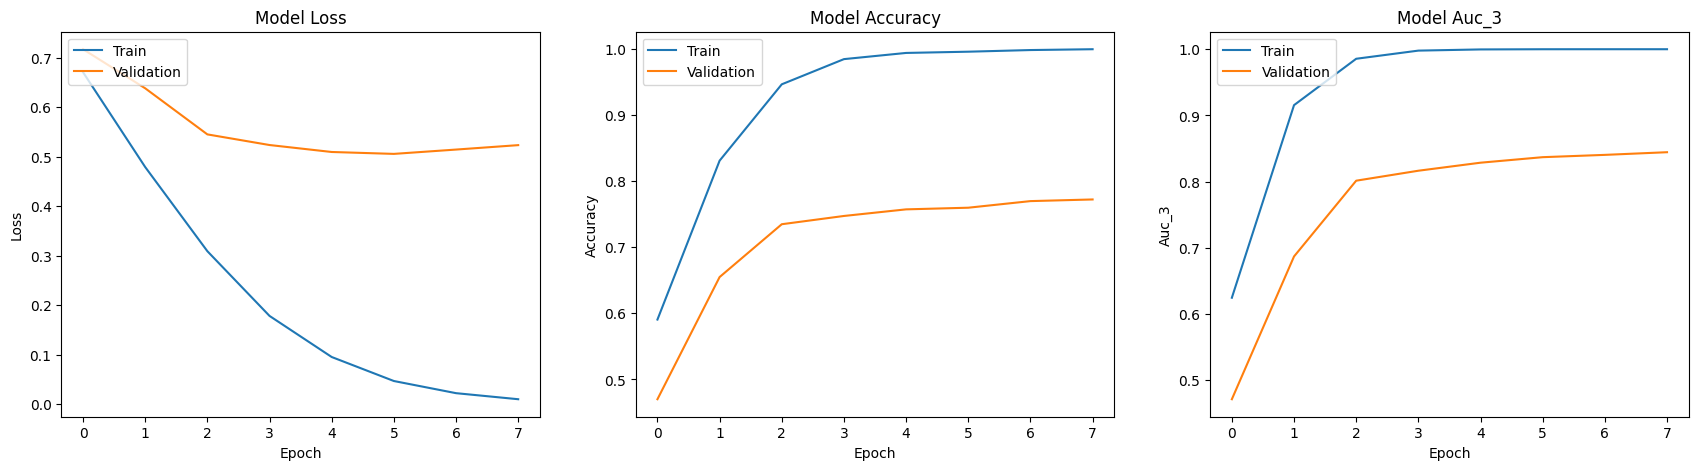

In [ ]:
plot_history2(results_no_att.history)

# **Coba hitung optical flow**

In [ ]:
DIR2 = "drive/MyDrive/dataset"

In [ ]:
os.listdir(DIR)

In [ ]:
class FrameGeneratorFlow:
    def __init__(self, path, training=False):
        """ Returns a set of frames with their associated label.
          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path

        self.training = training
        self.class_names = ['NonFight', 'Fight']
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        if self.training:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        else:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        classes = [p.parent.name for p in video_paths]

        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = self.read_npy_file(path)
            video_frames_flow = self.flow_to_color(video_frames)
            label = self.class_ids_for_name[name]
            label = tf.keras.utils.to_categorical(label, num_classes=len(self.class_names))
            yield video_frames_flow, label


    def read_npy_file(self, path):
        data = np.load(path)
        data = np.float32(data)
        data = data/255.0

        # frame = data[:, :, :, :3]
        # flow = data[:, :, :, 3:]
        # return frame, flow
        return data

    def flow_to_color(self, video):
        rgb_flows = []

        first_frame = video[0]

        prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

        # Creates an image filled with zero intensities with the same dimensions as the frame
        mask = np.zeros_like(first_frame)

        # Sets image saturation to maximum
        mask[..., 1] = 255

        for i in range(1, len(video)):
            frame = video[i]


            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Calculates dense optical flow by Farneback method
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                                None,
                                                0.5, 3, 15, 3, 5, 1.2, 0)

            # Computes the magnitude and angle of the 2D vectors
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

            # Sets image hue according to the optical flow direction
            mask[..., 0] = angle * 180 / np.pi / 2

            # Sets image value according to the optical flow magnitude (normalized)
            mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

            # Converts HSV to RGB (BGR) color representation
            rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

            resized_rgb = cv2.resize(rgb, (224, 224), interpolation=cv2.INTER_AREA)
            rgb_flows.append(resized_rgb)

            prev_gray = gray


        return np.array(rgb_flows)

In [ ]:
train_file = Path(DIR2).joinpath("train").with_suffix('')
test_file = Path(DIR2).joinpath("val").with_suffix('')
train_file

In [ ]:
fg = FrameGeneratorFlow(train_file, training=True)

# test
frames, label = next(fg())
print(fg)
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

In [ ]:
def to_gif(images, path):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave(path, converted_images, fps=3)
  return embed.embed_file(path)

In [ ]:
to_gif(frames, './animation.gif')

In [ ]:
to_gif(frames_flow, './animation_flow.gif')

In [ ]:
# buat tf.data.Dataset
batch_size = 8

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(2,), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGeneratorFlow(train_file, training=True),
                                          output_signature=output_signature)


test_ds = tf.data.Dataset.from_generator(FrameGeneratorFlow(test_file),
                                          output_signature=output_signature)


In [ ]:
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size)
test_ds = test_ds.shuffle(buffer_size=1000).batch(batch_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# test data
for frames, labels in train_ds.take(5):
    print(labels)

print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg',
                                                  weights='imagenet')

# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (20, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model_opt = tf.keras.Model(inputs=video_input, outputs=dense_4)

model_opt.summary()

In [ ]:
epochs = 20
lr = 1e-6

In [ ]:
model_opt.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy', AUC(multi_label=False)])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
results_opt = model_opt.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/20
200/200 [==============================] - 911s 3s/step - loss: 0.6923 - accuracy: 0.5481 - auc_7: 0.5577 - val_loss: 0.6897 - val_accuracy: 0.6825 - val_auc_7: 0.6932
Epoch 2/20
200/200 [==============================] - 99s 496ms/step - loss: 0.6893 - accuracy: 0.6019 - auc_7: 0.6221 - val_loss: 0.6832 - val_accuracy: 0.6875 - val_auc_7: 0.7156
Epoch 3/20
200/200 [==============================] - 99s 495ms/step - loss: 0.6827 - accuracy: 0.6200 - auc_7: 0.6489 - val_loss: 0.6699 - val_accuracy: 0.6975 - val_auc_7: 0.7339
Epoch 4/20
200/200 [==============================] - 99s 495ms/step - loss: 0.6696 - accuracy: 0.6369 - auc_7: 0.6725 - val_loss: 0.6469 - val_accuracy: 0.7050 - val_auc_7: 0.7516
Epoch 5/20
200/200 [==============================] - 100s 500ms/step - loss: 0.6474 - accuracy: 0.6644 - auc_7: 0.7055 - val_loss: 0.6153 - val_accuracy: 0.7150 - val_auc_7: 0.7693
Epoch 6/20
200/200 [==============================] - 99s 495ms/step - loss: 0.6144 - accuracy: 

In [ ]:
result_metric_opt = model_opt.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 7s 148ms/step - loss: 0.5077 - accuracy: 0.7450 - auc_7: 0.8371


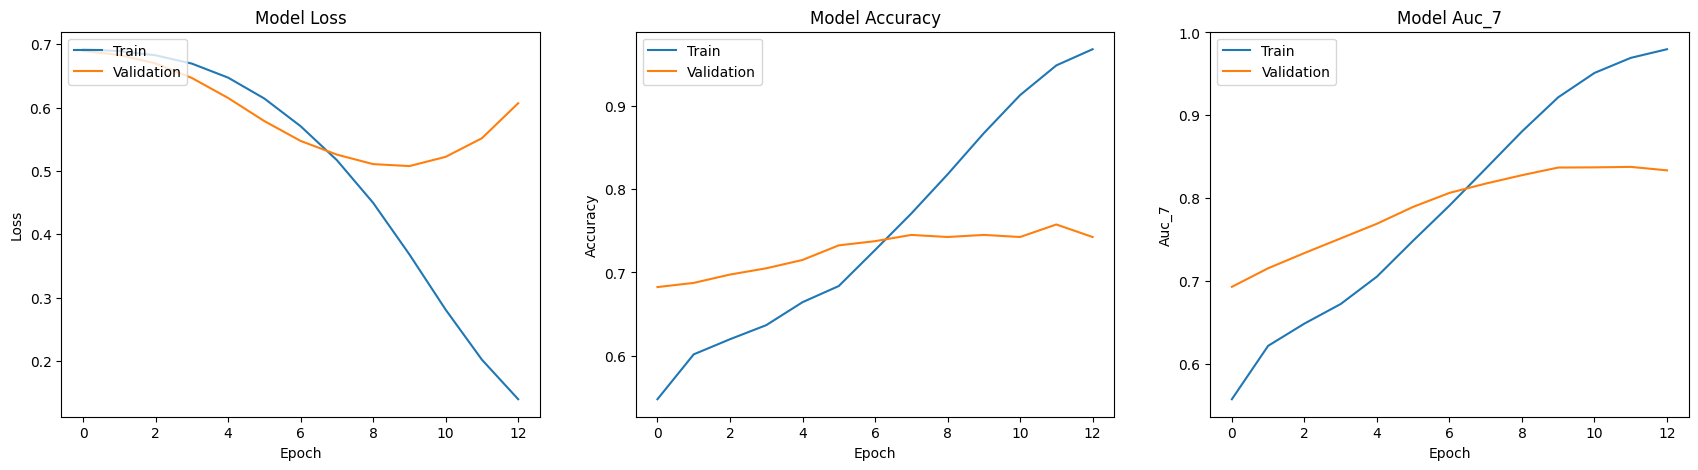

In [ ]:
plot_history2(results_opt.history)

# **coba attention 10**

In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg', weights='imagenet')

# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (20, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=10, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model_10= tf.keras.Model(inputs=video_input, outputs=dense_4)

model_10.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_8 (TimeDi  (None, 20, 7, 7, 2048)       2358771   ['input_18[0][0]']            
 stributed)                                               2                                       
                                                                                                  
 conv_lstm2d_15 (ConvLSTM2D  (None, 20, 7, 7, 256)        2123468   ['time_distributed_8[0][0]']  
 )                                                        8                                       
                                                                                           

In [ ]:
epochs = 20
lr = 1e-6

In [ ]:
model_10.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy', AUC(multi_label=False)])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
results_10= model_10.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/20
200/200 [==============================] - 129s 513ms/step - loss: 0.6922 - accuracy: 0.5944 - auc_4: 0.5812 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_auc_4: 0.4899
Epoch 2/20
200/200 [==============================] - 99s 496ms/step - loss: 0.6868 - accuracy: 0.6700 - auc_4: 0.7250 - val_loss: 0.6825 - val_accuracy: 0.7125 - val_auc_4: 0.7796
Epoch 3/20
200/200 [==============================] - 99s 496ms/step - loss: 0.6681 - accuracy: 0.7031 - auc_4: 0.7608 - val_loss: 0.6432 - val_accuracy: 0.7425 - val_auc_4: 0.8225
Epoch 4/20
200/200 [==============================] - 99s 497ms/step - loss: 0.6165 - accuracy: 0.7163 - auc_4: 0.7956 - val_loss: 0.5722 - val_accuracy: 0.7350 - val_auc_4: 0.8283
Epoch 5/20
200/200 [==============================] - 100s 502ms/step - loss: 0.5367 - accuracy: 0.7487 - auc_4: 0.8387 - val_loss: 0.5119 - val_accuracy: 0.7550 - val_auc_4: 0.8371
Epoch 6/20
200/200 [==============================] - 99s 496ms/step - loss: 0.4583 - accurac

In [ ]:
result_metric_10 = model_10.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 7s 149ms/step - loss: 0.4880 - accuracy: 0.7600 - auc_4: 0.8418


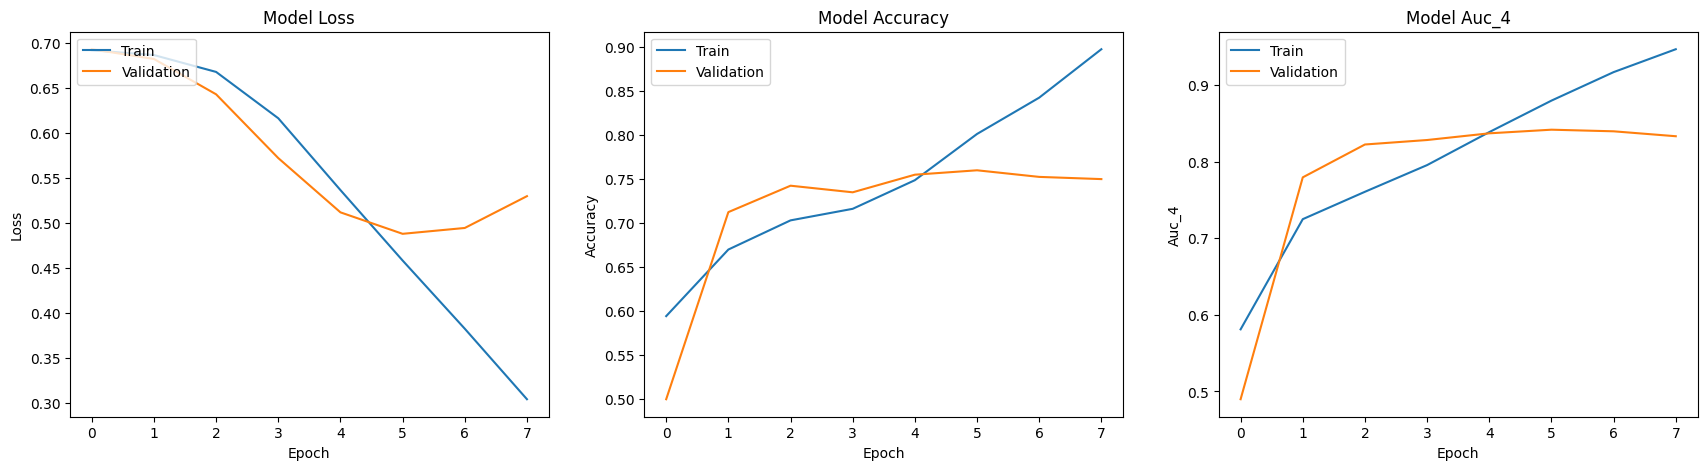

In [ ]:
plot_history2(results_10.history)